In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

np.set_printoptions(precision=4)
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from tqdm import tqdm

In [2]:
energy = pd.read_csv('energy.csv')

In [3]:
energy['dt'] = pd.to_datetime(energy['Unnamed: 0'])
energy.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
demand = energy[['ND']]

In [5]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(nrows=2, figsize=(12, 12), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    return fig, ax

(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcb6f80fa0>,
       dtype=object))

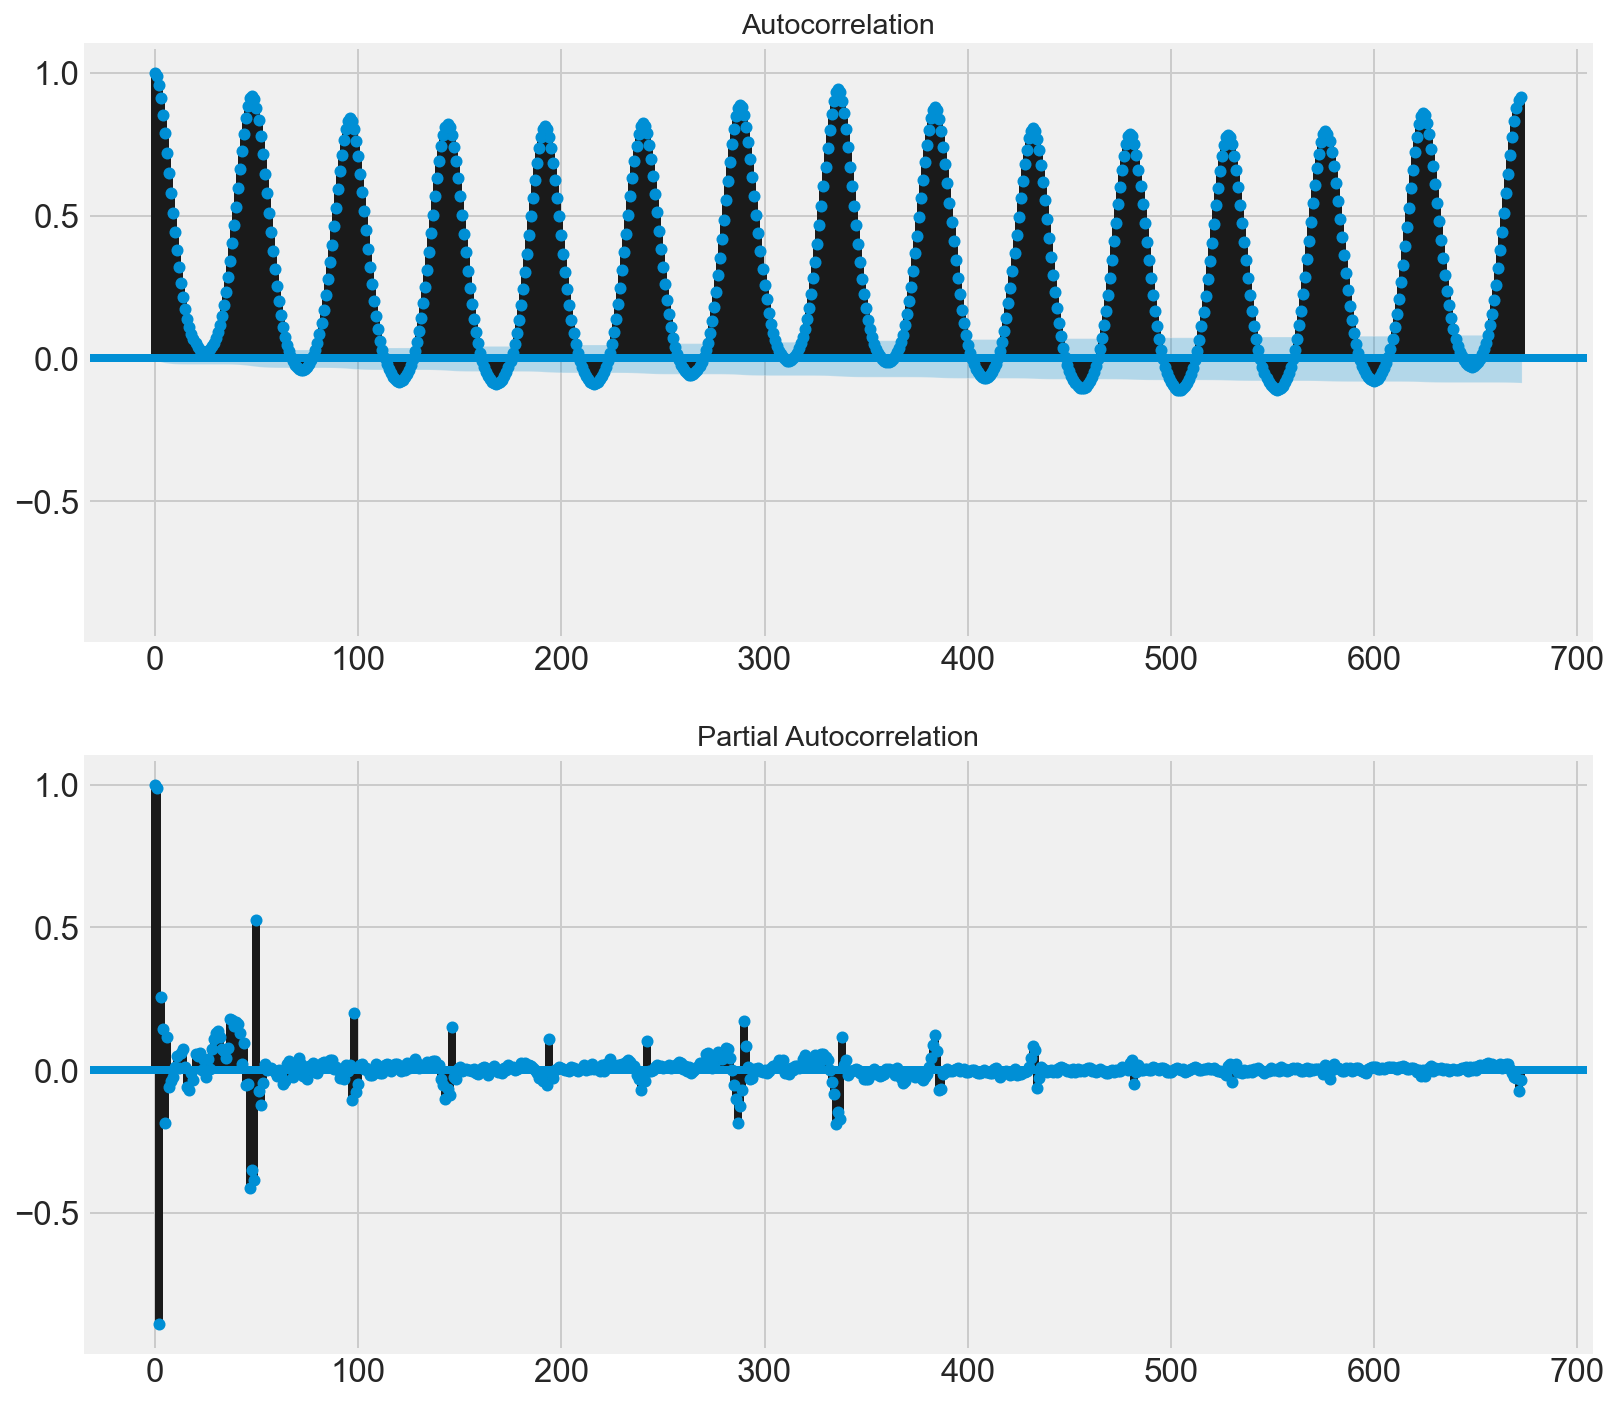

In [73]:
autocorr_plots(demand, lags=(48*7*2))

The autocorrelation and partial autocorrelation plots give us an indication of how to go about modelling the time series.

ACF - 0 correlation at 24 periods apart. This is interesting that it's that low. For some EDA, it would probably be useful to check out the distributions of the separate periods - I'd say this zero correlation suggests that nighttime loads are pretty predictably at a low baseline, and larger than usual loads during the day doesn't suggest much about the nighttime loads.

*A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.*

PACF --- First seasonal (48-period) lag is definitely a big one. First two period lags also. It also looks likely that one weekly lag will be useful.

**Let's think about stationarity...**

*A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.*

Well, the statistical properties of the load data absolutely depend on time - the period, the day of week, the month of year. But they are reverting statistical properties - the properties are the same for each same-season observation (12pm Tuesday Week 2 March)

Let's compare the raw data with the differenced data for multiple differencing steps. First, let's look at a single 3-week period.

In [96]:
five_week_sample = demand.iloc[(48*7*100):(48*7*106)]

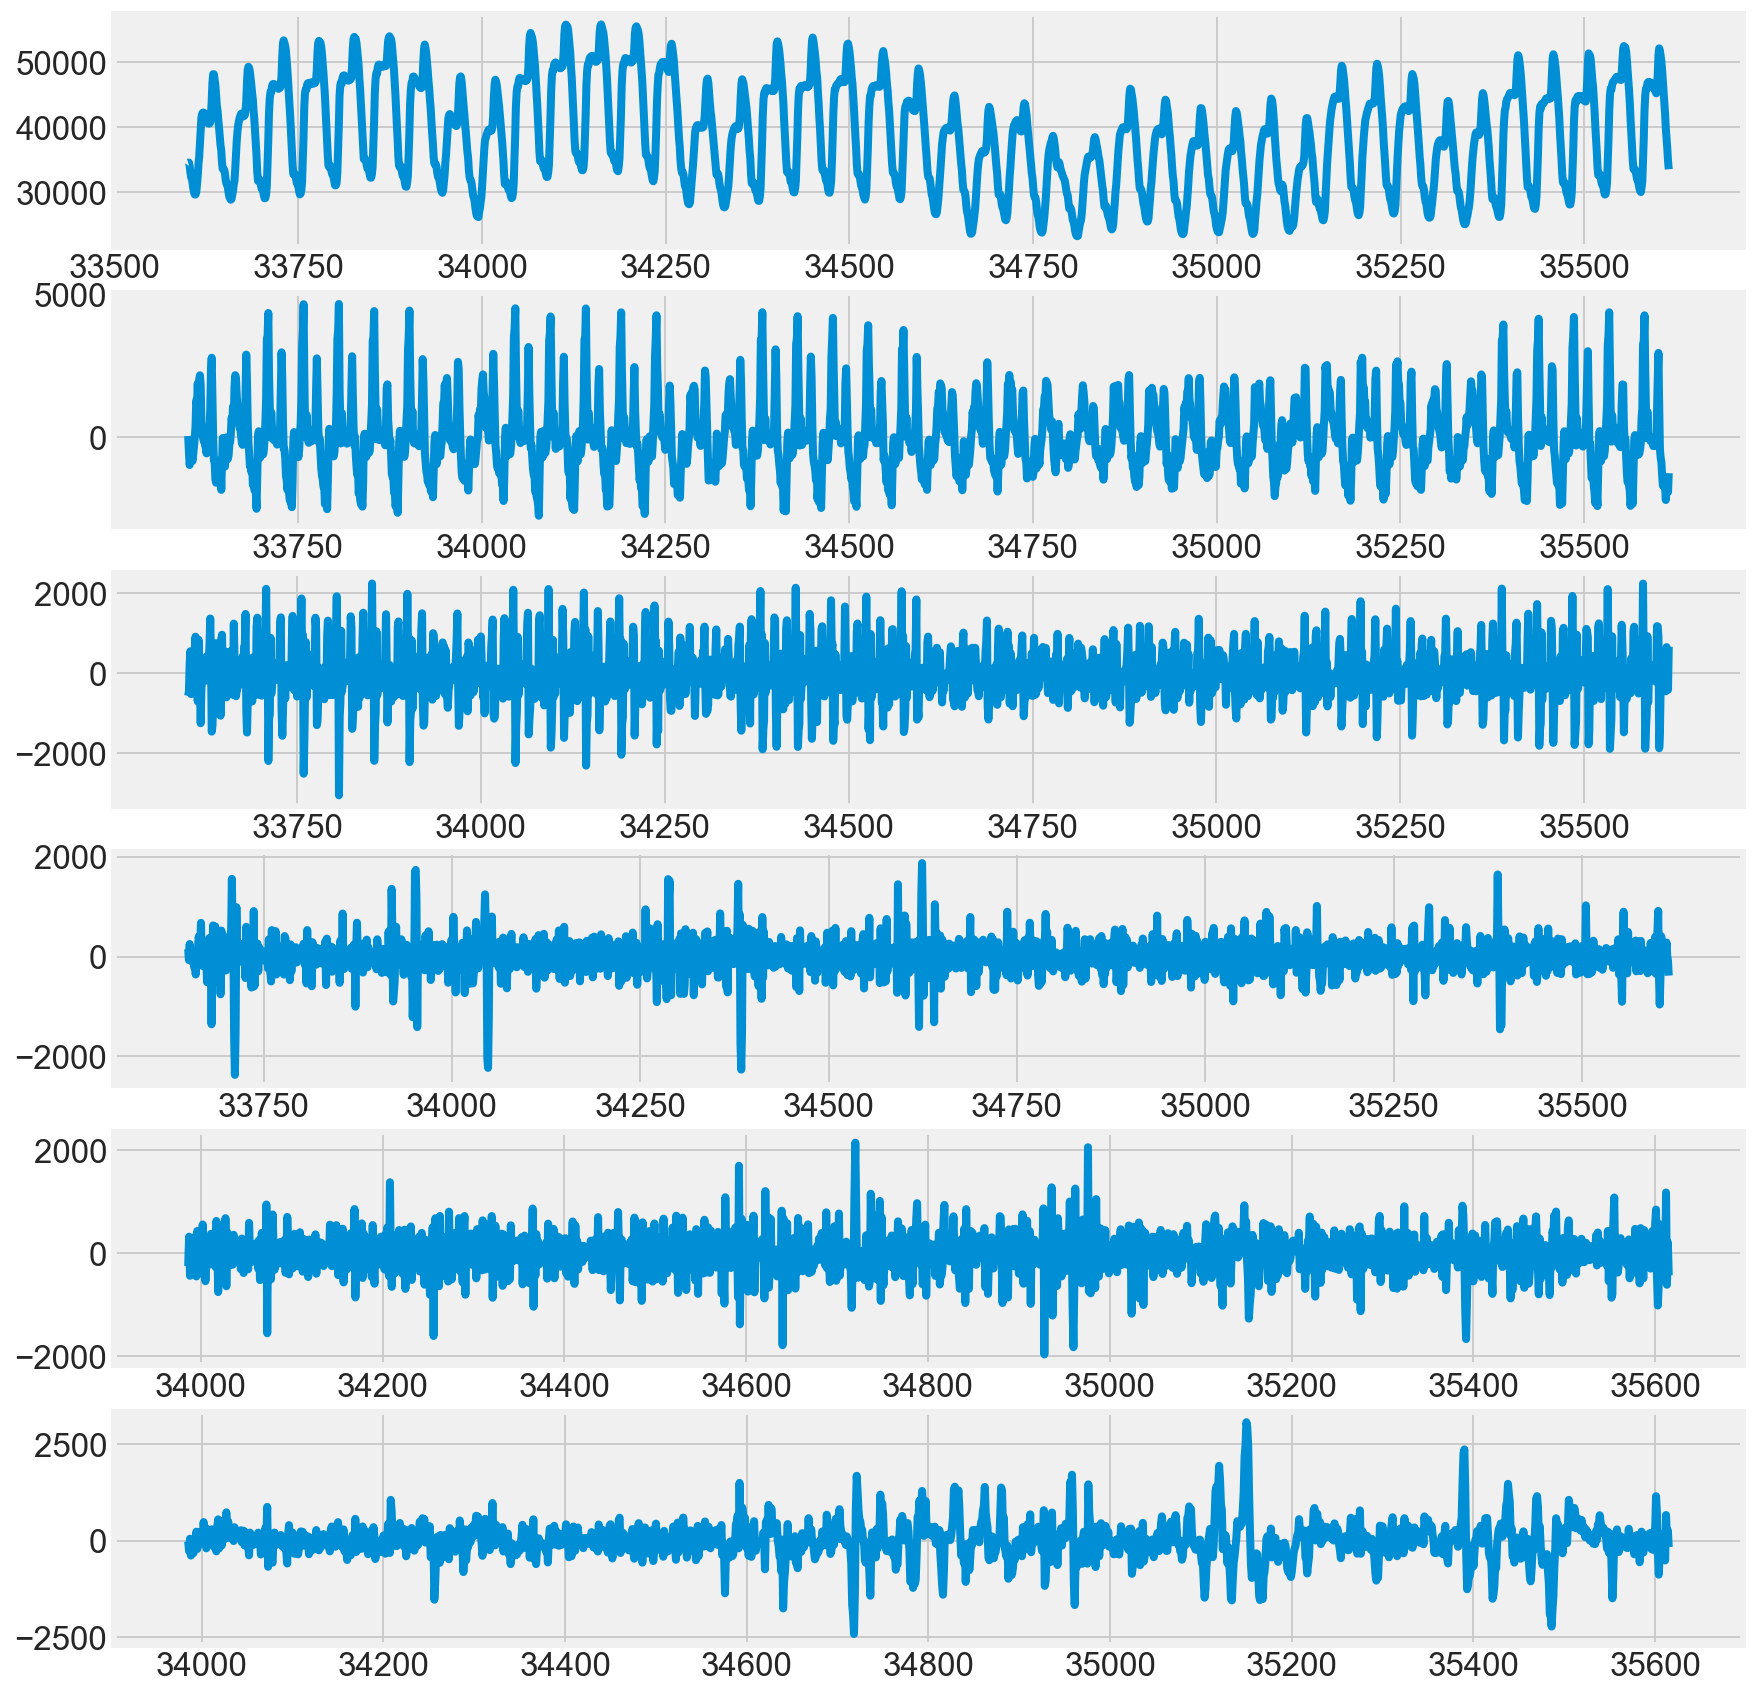

In [170]:
fig, ax = plt.subplots(nrows=6, figsize=(13,15))
ax[0].plot(five_week_sample)
ax[1].plot(five_week_sample.diff().dropna())
ax[2].plot(five_week_sample.diff().diff().dropna())
ax[3].plot(five_week_sample.diff(48).diff().diff().dropna())
ax[4].plot(five_week_sample.diff().diff().diff(48).diff((48*7)).dropna())
ax[5].plot(five_week_sample.diff(48).diff((48*7)).diff().dropna())
plt.show()

(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcc0a3f190>,
       dtype=object))

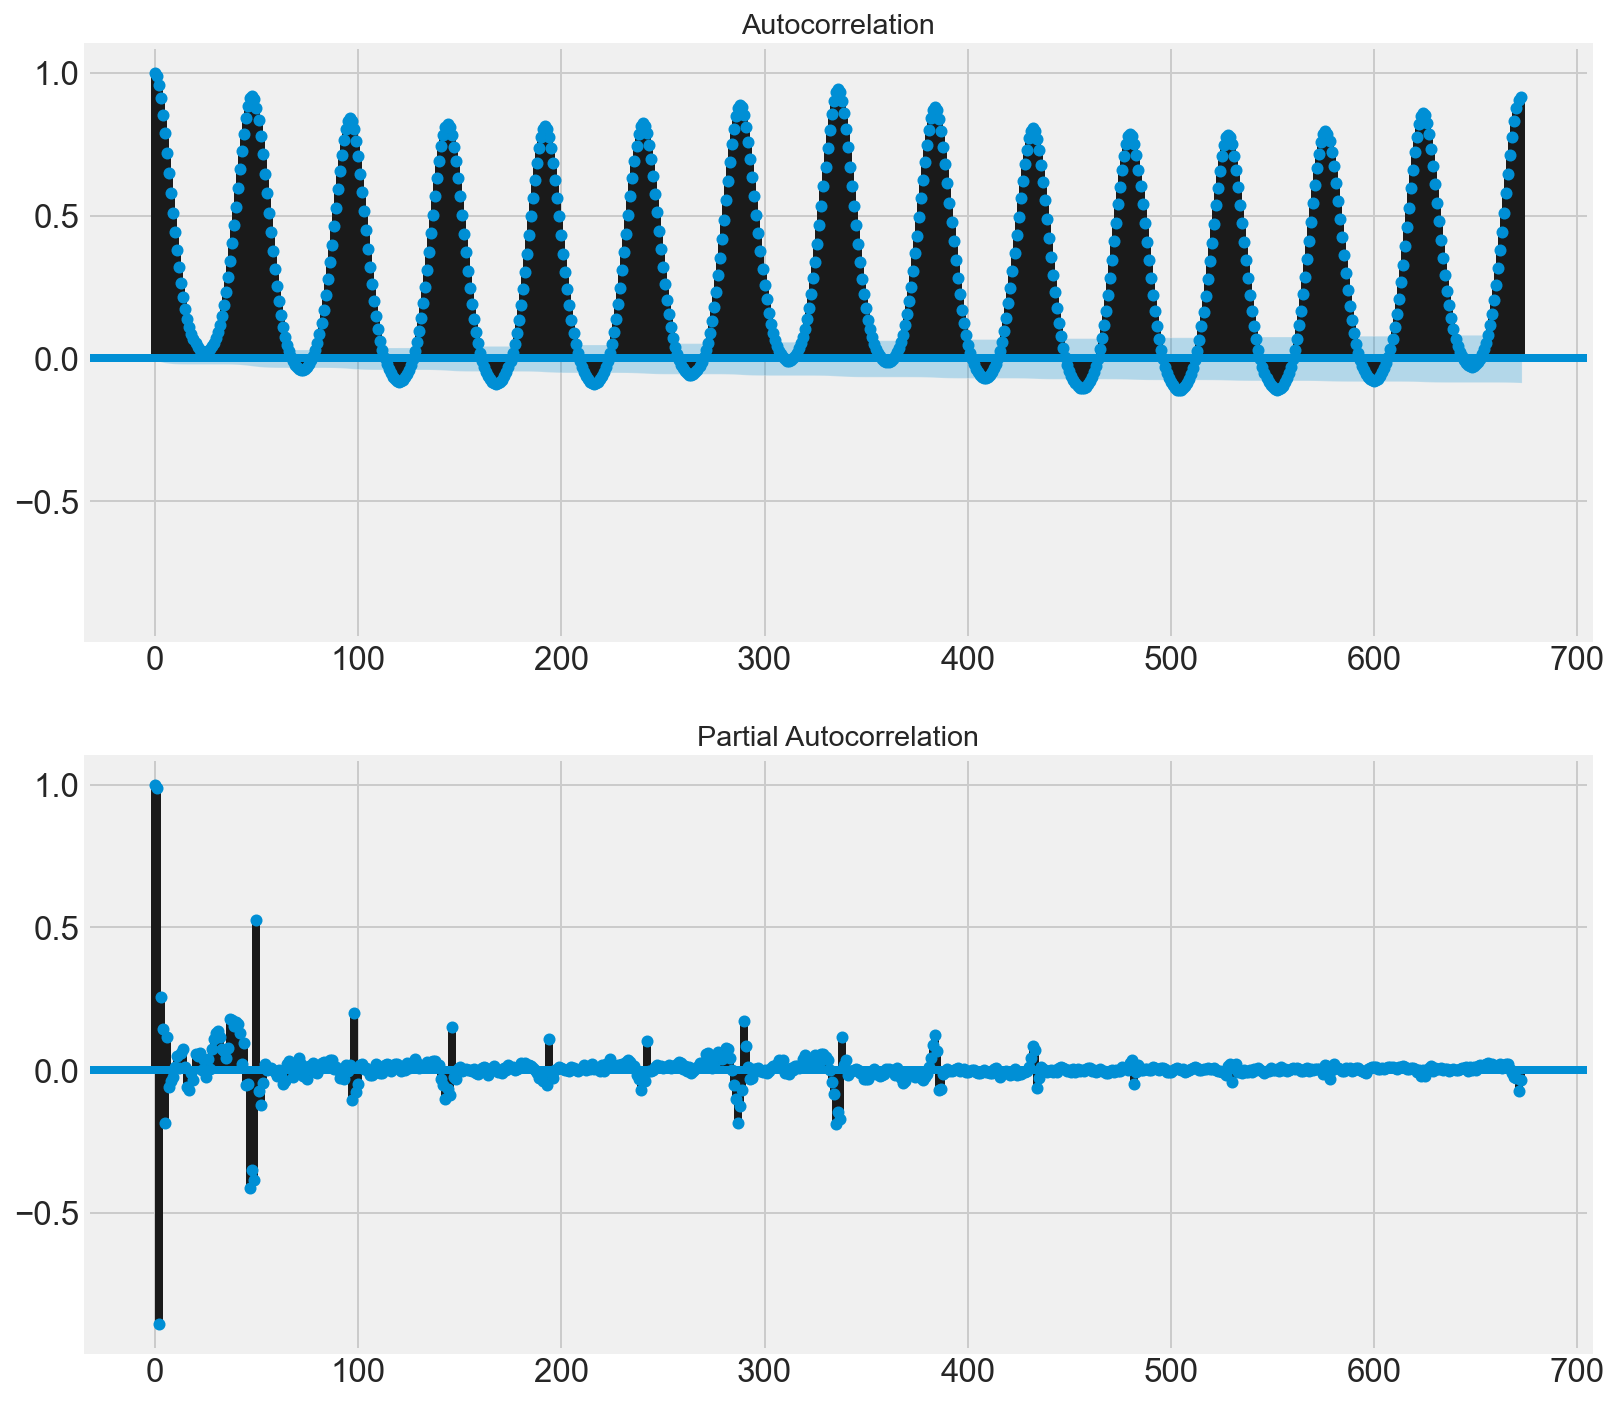

In [117]:
autocorr_plots(demand, lags=(48*7*2))
# See some serious autocorrelation here. Daily (and weekly) seasonality is behind it. 
# The autocorrelations barely die out. Checking on a longer time scale (way more lags), i'd expect it to slowly decrea

(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcbddc9eb0>,
       dtype=object))

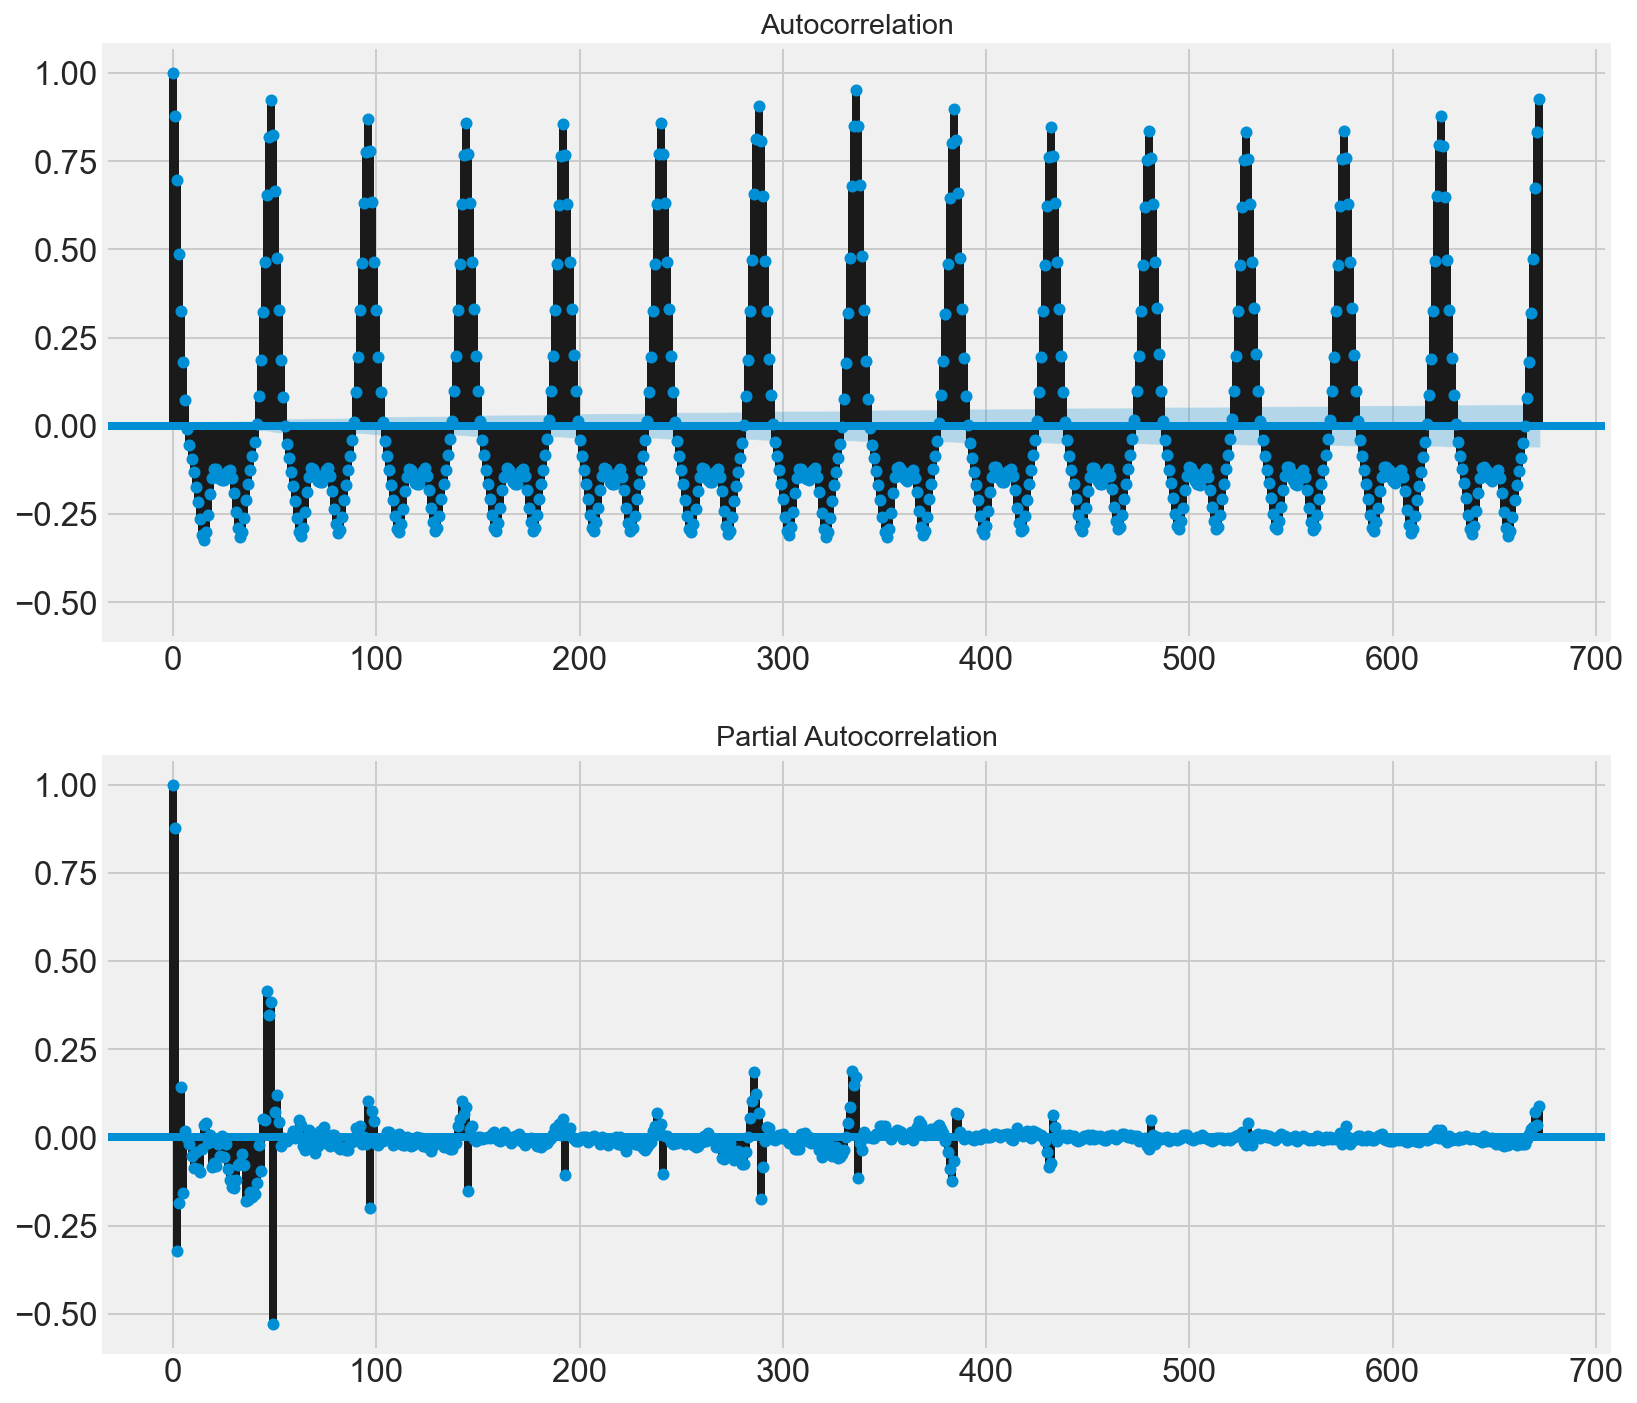

In [118]:
autocorr_plots(demand.diff().dropna(), lags=(48*7*2))
# First differences. Observations are now the difference between this period and last period in demand.
# Strong positive first order autocorrelation for an observation (12.30-12.00) then means:
    # 12pm < 12.30pm   ---->   11.30 < 12.00
    # Tendency for demand movements to be associated with eachother (positively or negatively)
    # I.e. when the period 12->13 demand increases in one day, it usually increases in another.
# Does a fair amount to get rid of the standard autocorrelation (not daily or weekly autocorrelation)

(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcc8674b80>,
       dtype=object))

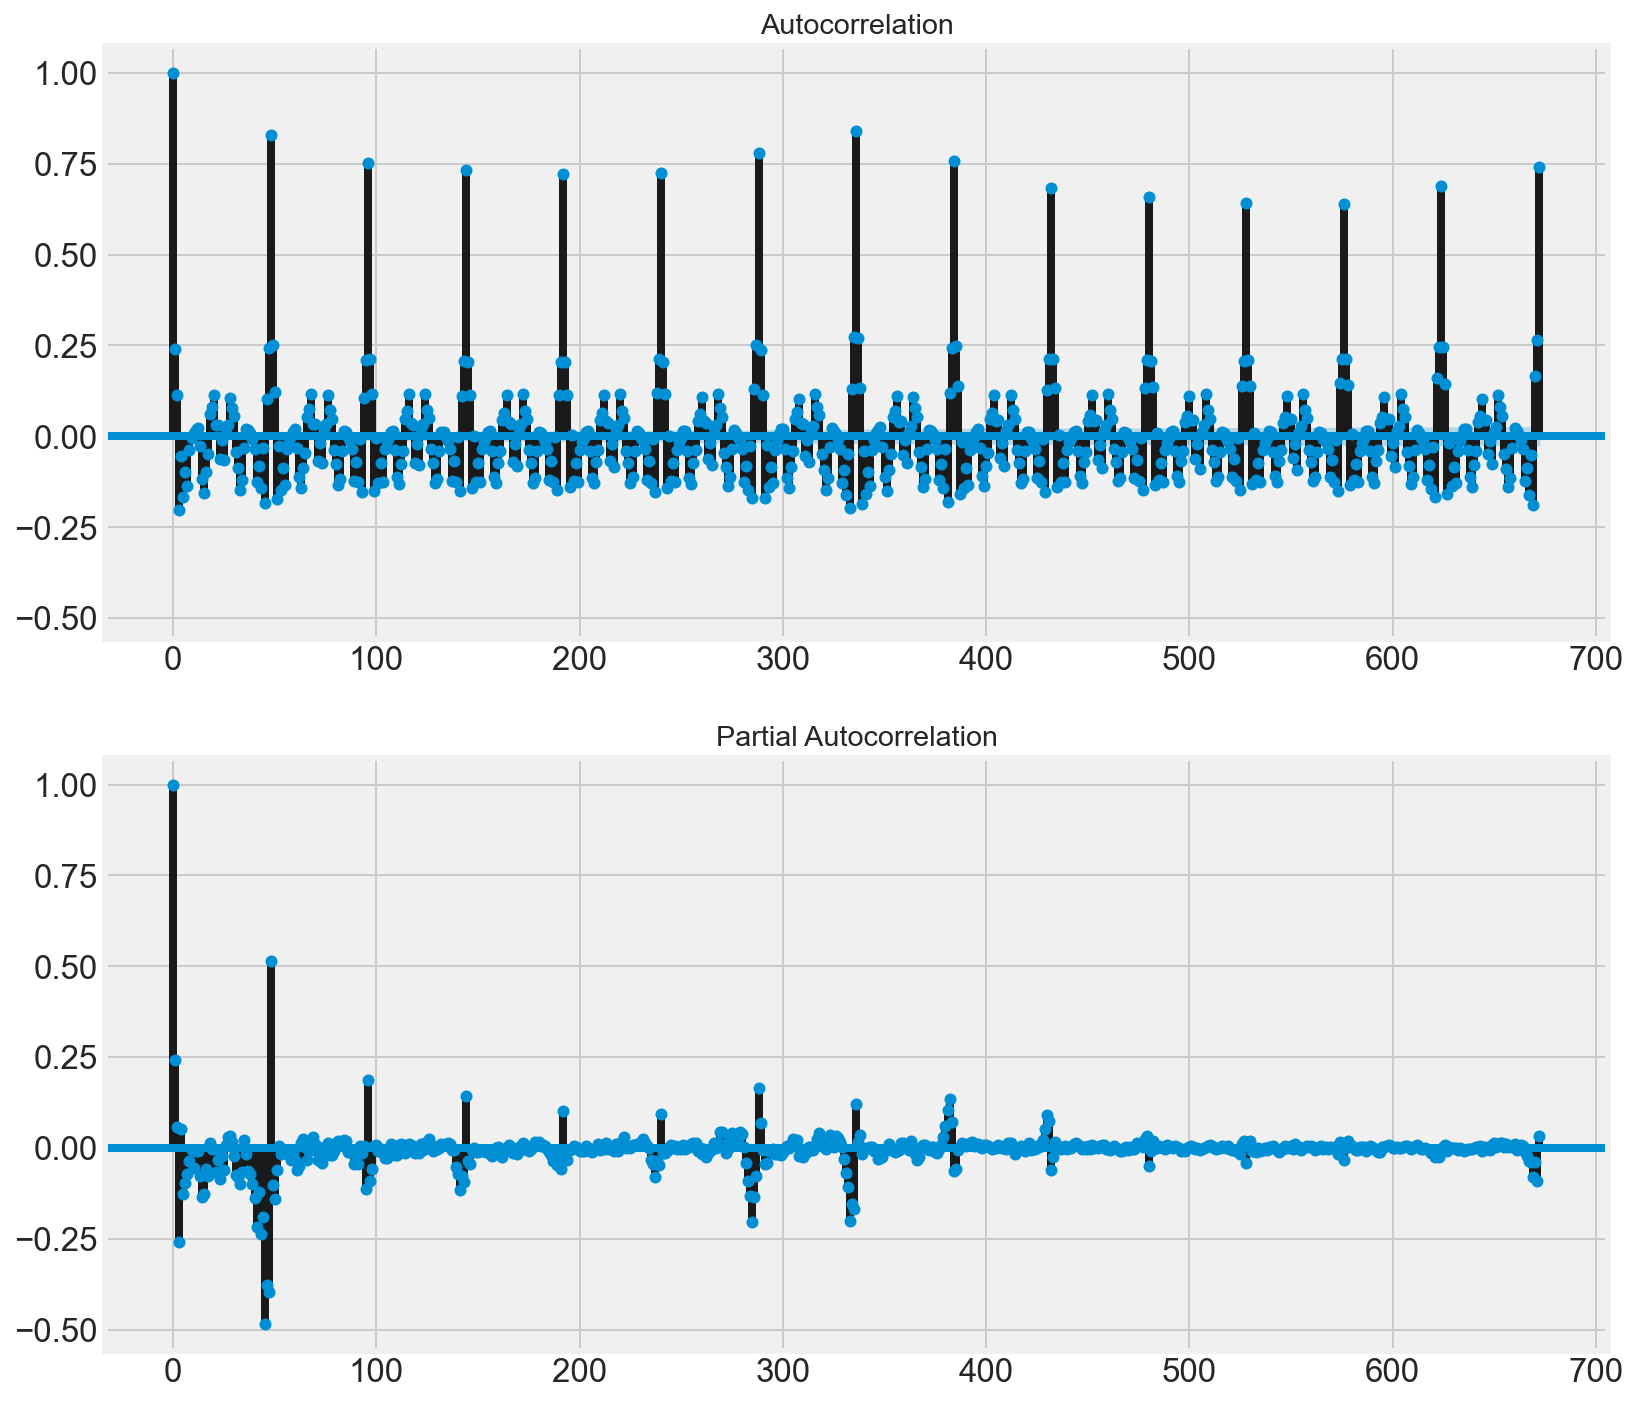

In [123]:
autocorr_plots(demand.diff().diff().dropna(), lags=(48*7*2))
# Differenced differences (this how they say it?).
# Observations now capture the difference between the most recent demand change to the second most recent demand chang
# I.e. a positive observation means that the increase in demand from period 12 to period 13 was greater than the 
# increase in demand from period 11 to period 12 --- or, the recent decrease was smaller than the previous decrease.

# In terms of gradients: 
    # first differences are analogous to gradient between neighbouring points(+ve, then increasing demand).
    # differences squared are analogous to the rate of change in the gradient(+ve, then increasingly increasing demand
    
    
### It seems that the second differencing has done a lot of good.
# ACF:
# We're now dealing with how much the changes in demand are changing (curvature of smoothed plots).
# Now, the only really significant same-day lag seems to be p=1 (maybe the negative p=3 as well? Dunno, see with score
# (others are far lower, even if still outside 95%)
# PACF:
# First daily lag seems the really big one. Maybe some more differencing will help

    # SARIMAX (1,2,0) ...

(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcc7d298b0>,
       dtype=object))

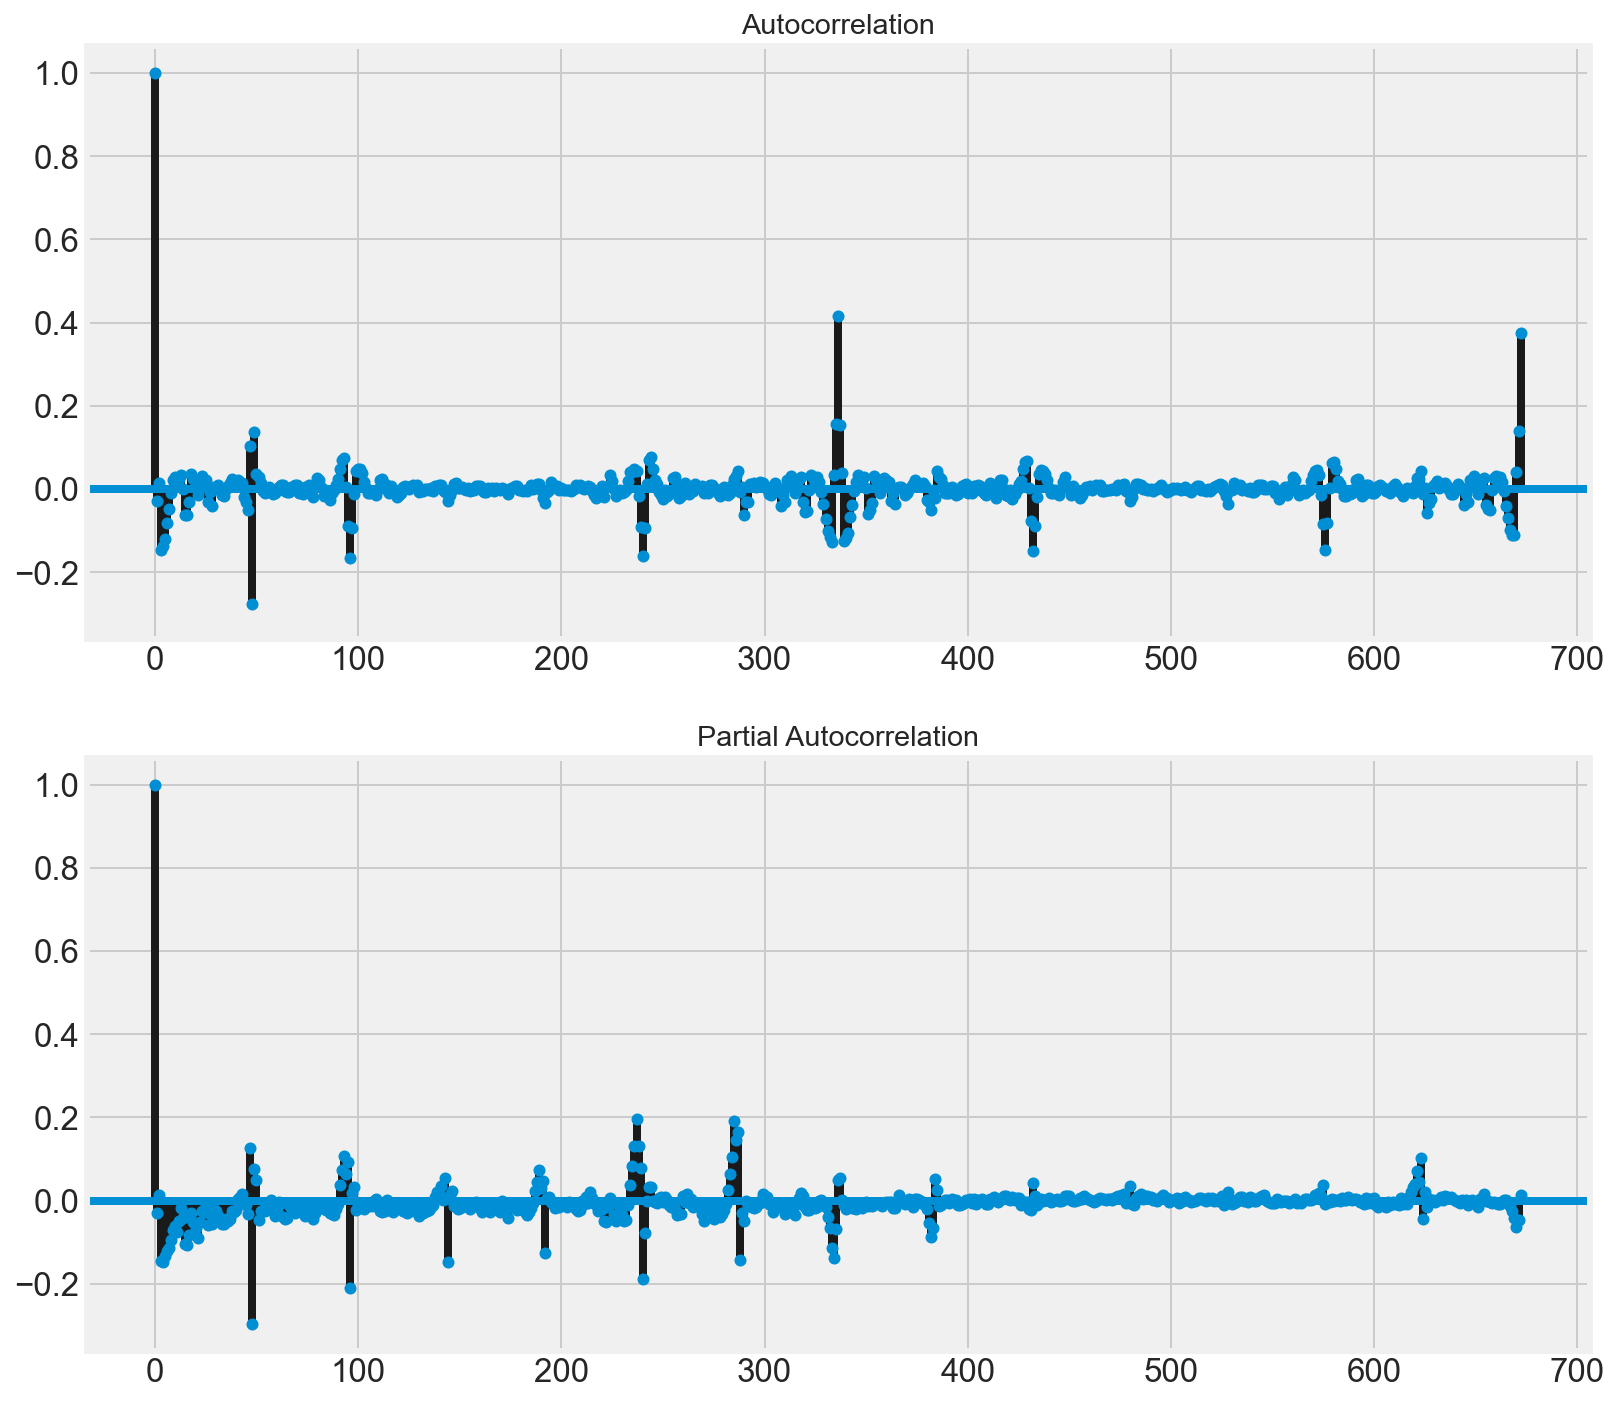

In [124]:
autocorr_plots(demand.diff().diff().diff(48).dropna(), lags=(48*7*2))
# Daily differences taken on top of non-seasonal differences in differences.
# Difference today compared to yesterday of - the rate of increase in the rate of increase.

# Intuition as to why there should be any correlation here isn't very obvious, and the autocorrelation function
# mostly reflects that --- except for a negative association with the one-day lag. I.e. if today's rate of increase
# of the increase in demand for these periods is greater than yesterday's, then yesterday's was likely smaller than
# the day before's. Kind of makes sense just from the fact that yesterday is more likely to have a relatively
# small value for these periods compared with other days.
# Based on this intuition, is there any reason to include the first day-lag of differenced differences in the
# modelling?

(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcbbe9a220>,
       dtype=object))

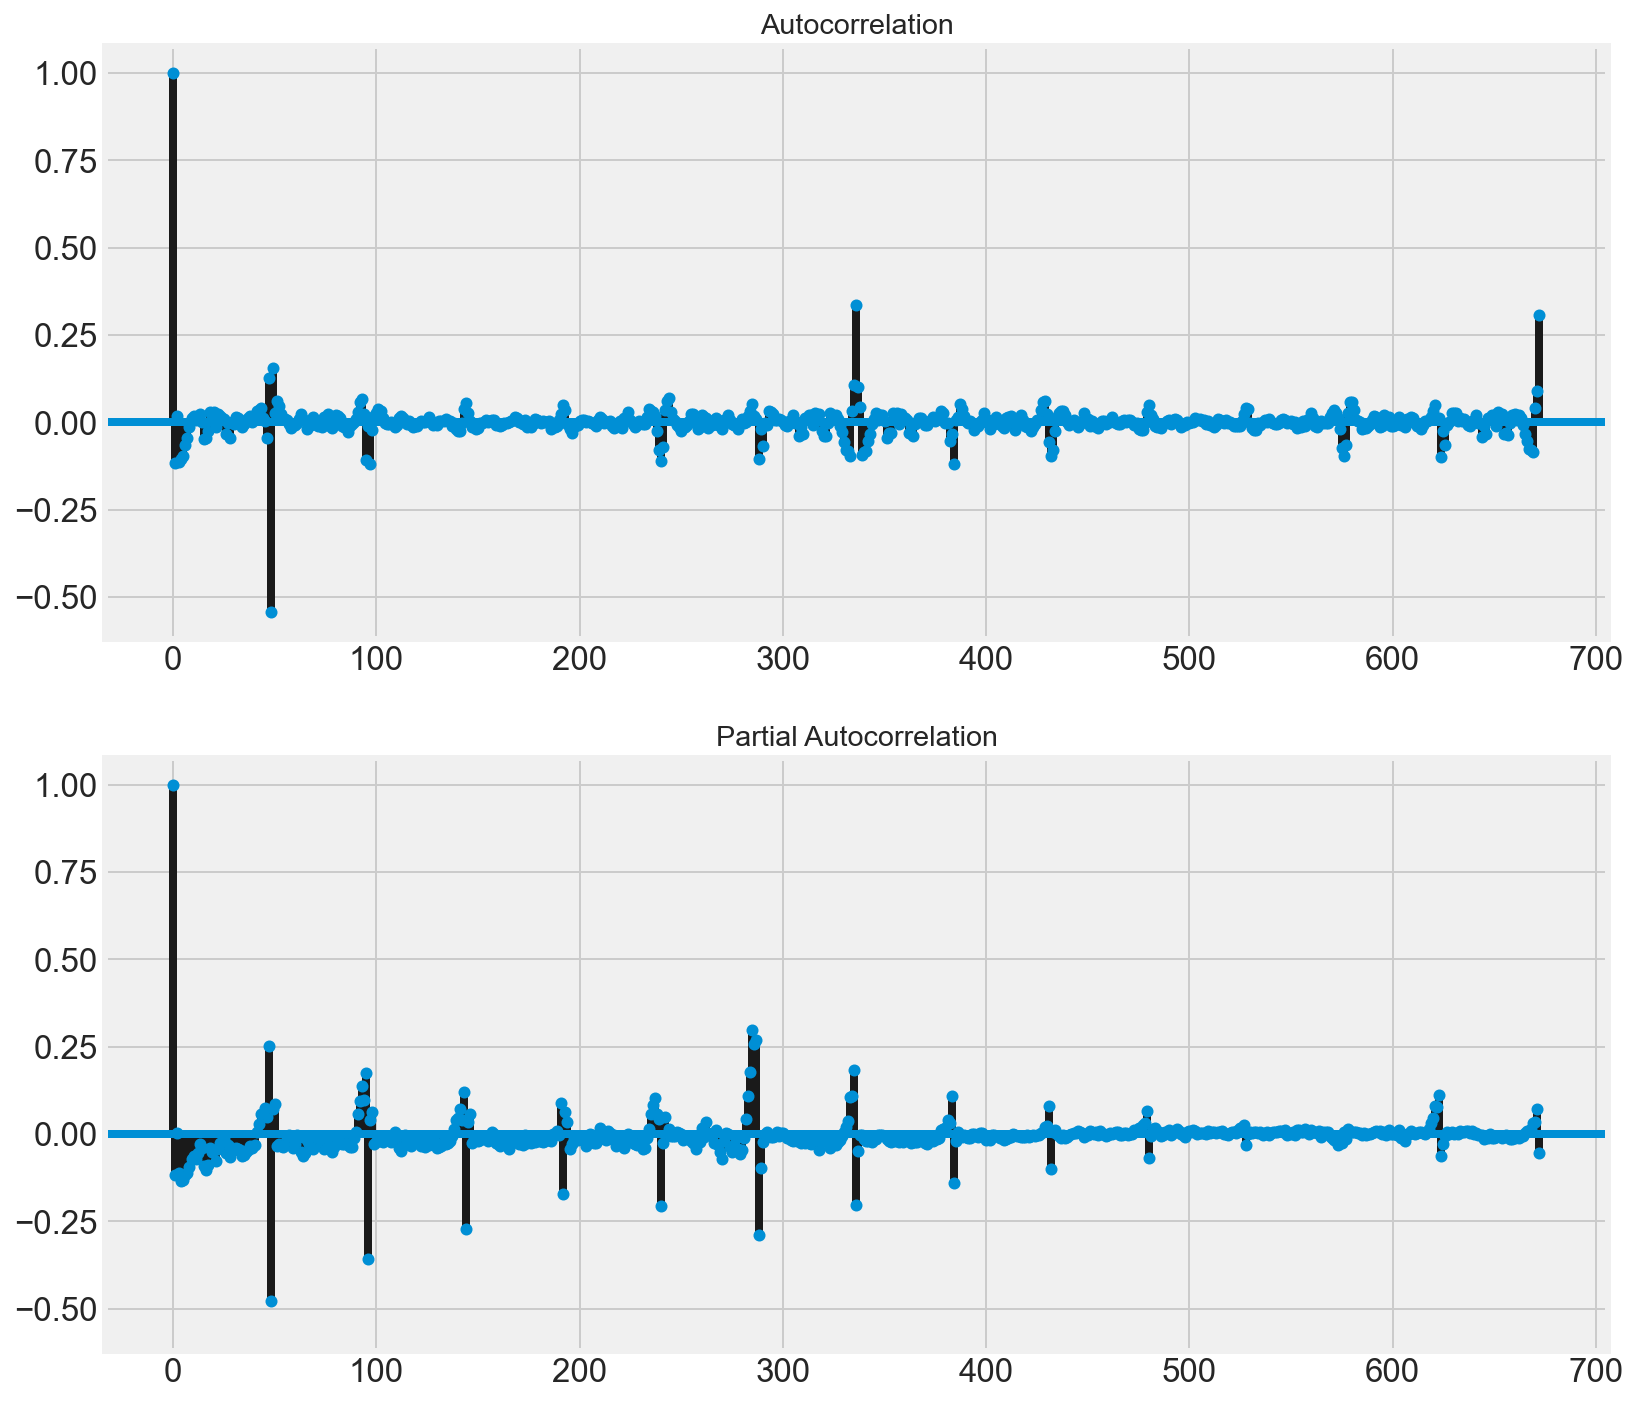

In [126]:
autocorr_plots(demand.diff().diff().diff(48).diff(48).dropna(), lags=(48*7*2))
# looks a lot better (tighter) to be fair.
# Why doesn't the daily differencing get rid of that first spike though??

# Trying a third daily differencing actually makes it way worse. Same with a third non-seasonal differencing.

In [157]:
a = acf(demand.diff().diff().diff(48).diff(48).dropna(), nlags=700)
a = pd.DataFrame(a, columns=['autocorrelation coefficient'])
a.insert(1, 'abs', a.apply(lambda x: abs(x)))
a.sort_values('abs', ascending=False).head(7)
# 336 = 48*7

/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


,autocorrelation coefficient,abs
0,1.000000,1.000000
48,-0.543241,0.543241
336,0.336341,0.336341
672,0.305730,0.305730
49,0.155457,0.155457
47,0.126734,0.126734
97,-0.120502,0.120502


(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcbfdca2b0>,
       dtype=object))

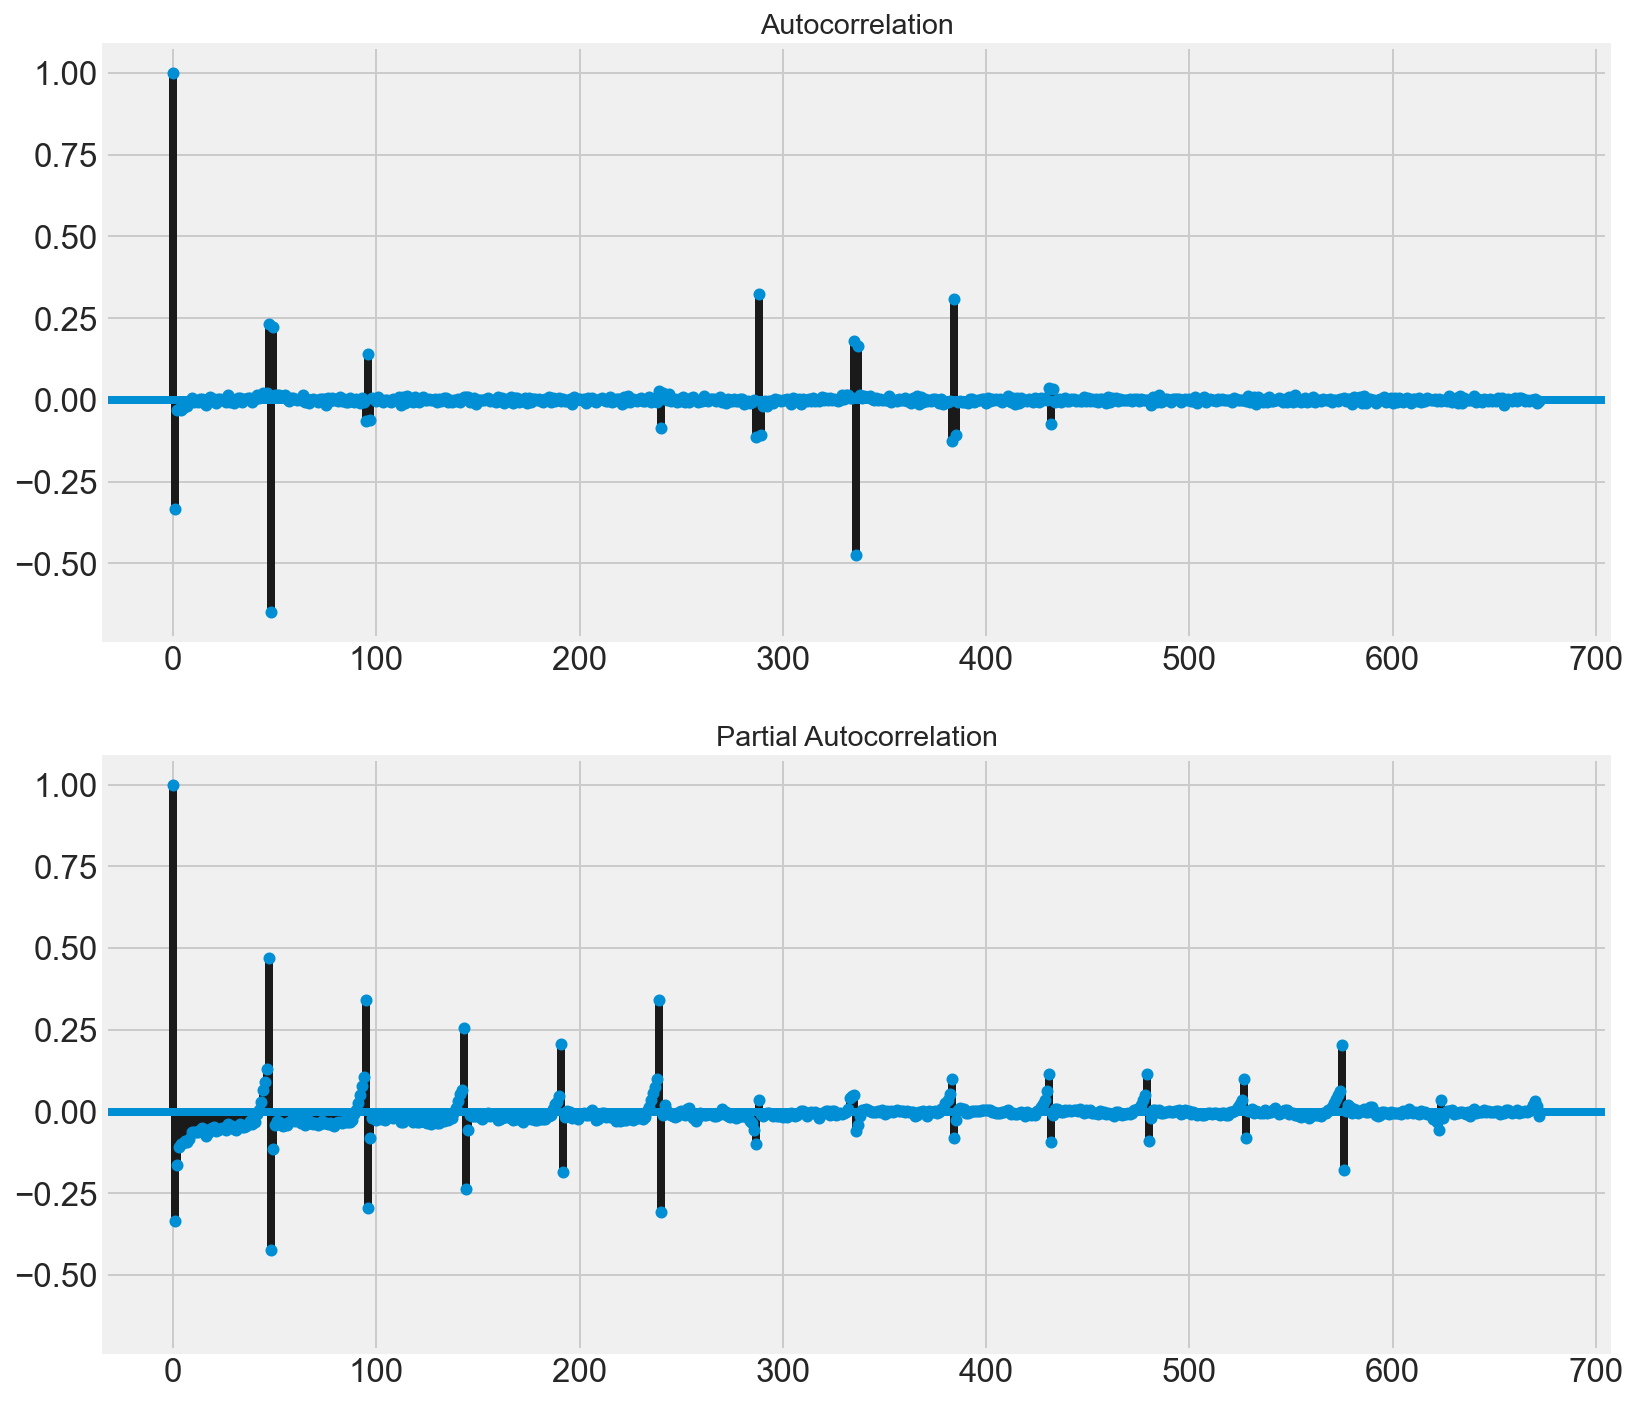

In [160]:
autocorr_plots(demand.diff().diff().diff(48).diff(48).diff((48*7)).dropna(), lags=(48*7*2))
# non-seasonal differences squared, daily differences squared, weekly differences.

# This actually looks worse than without the weekly differencing. I wonder if the double daily differencing is why

(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcbd2e7220>,
       dtype=object))

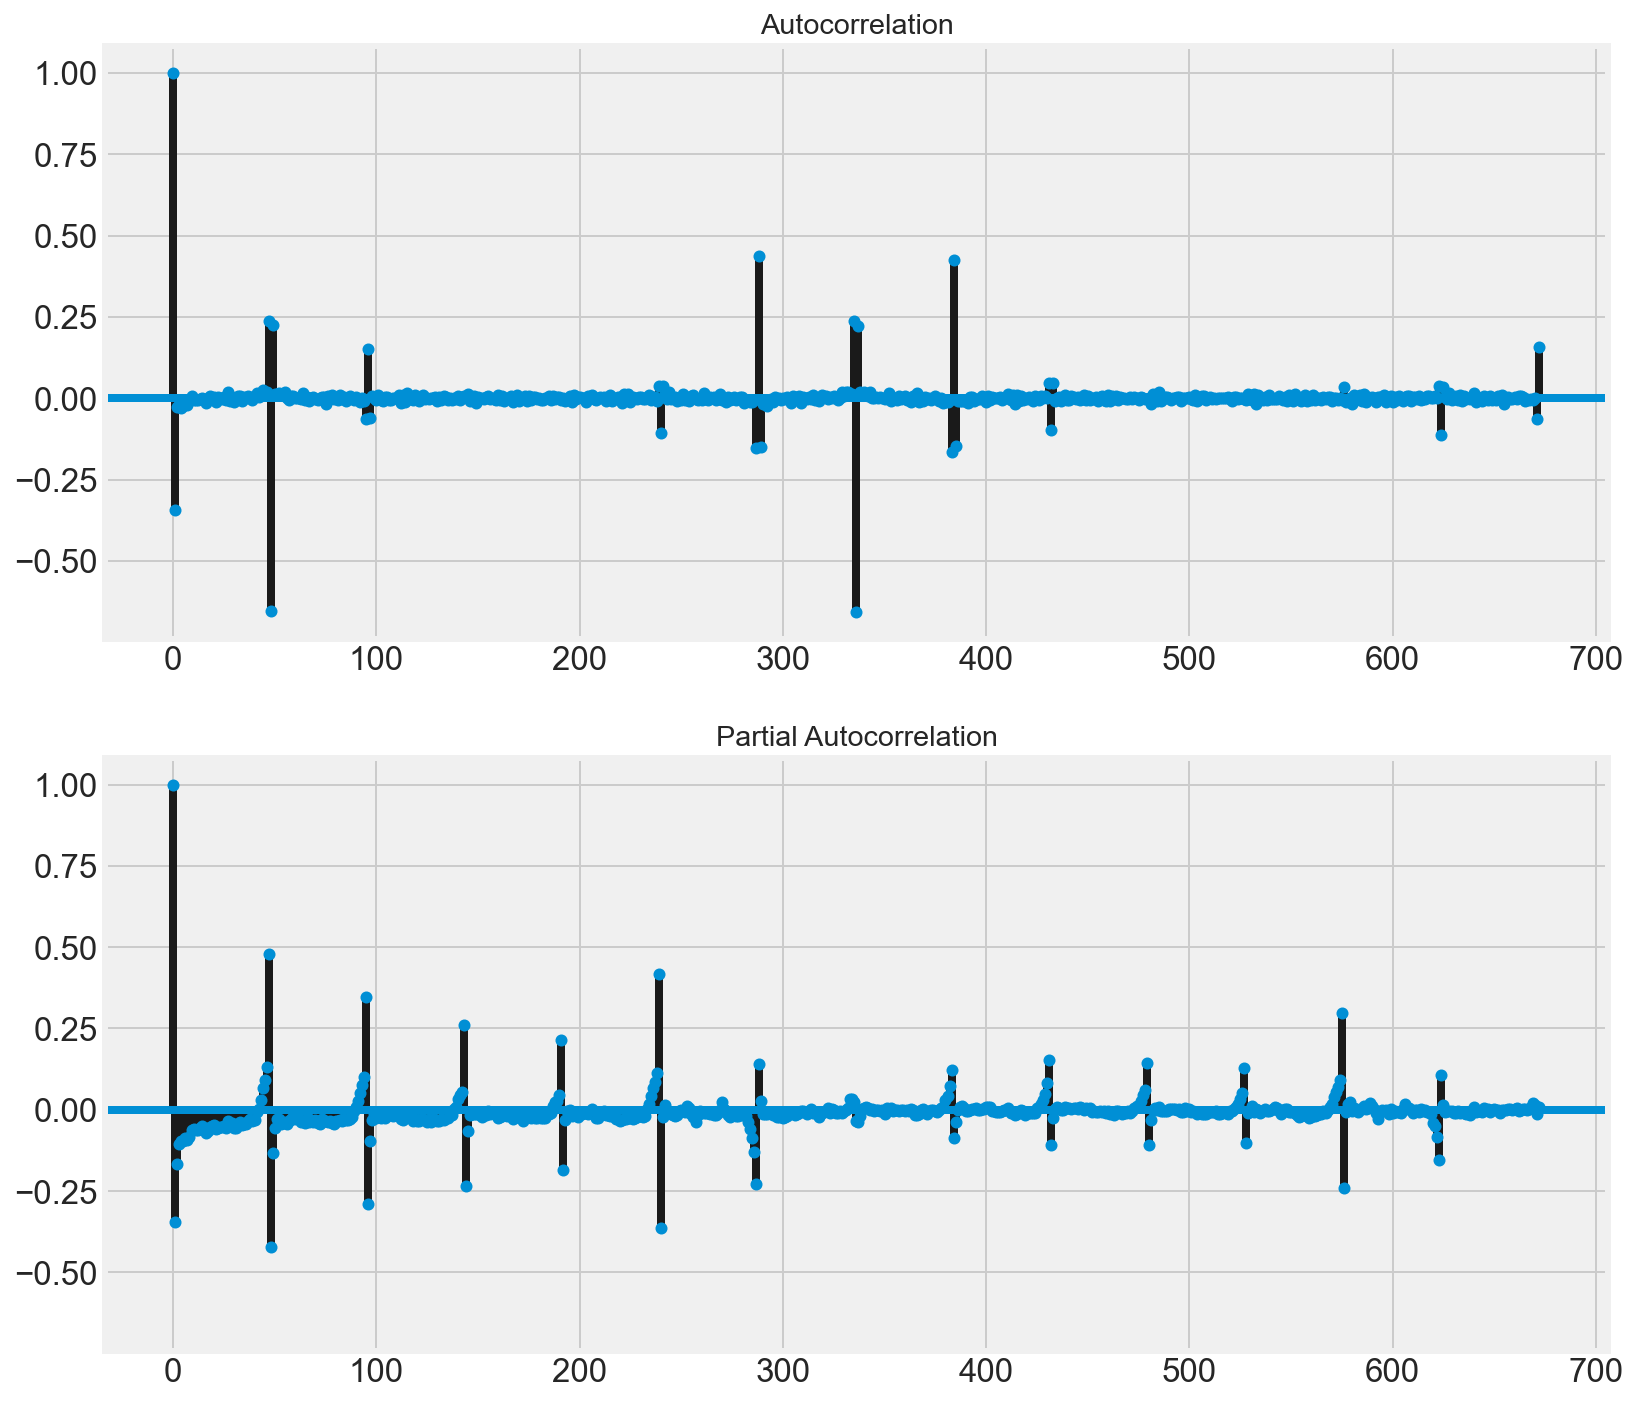

In [161]:
autocorr_plots(demand.diff().diff().diff(48).diff(48).diff((48*7)).diff((48*7)).dropna(), lags=(48*7*2))
# worse again.

(<Figure size 864x864 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcbddbeaf0>,
       dtype=object))

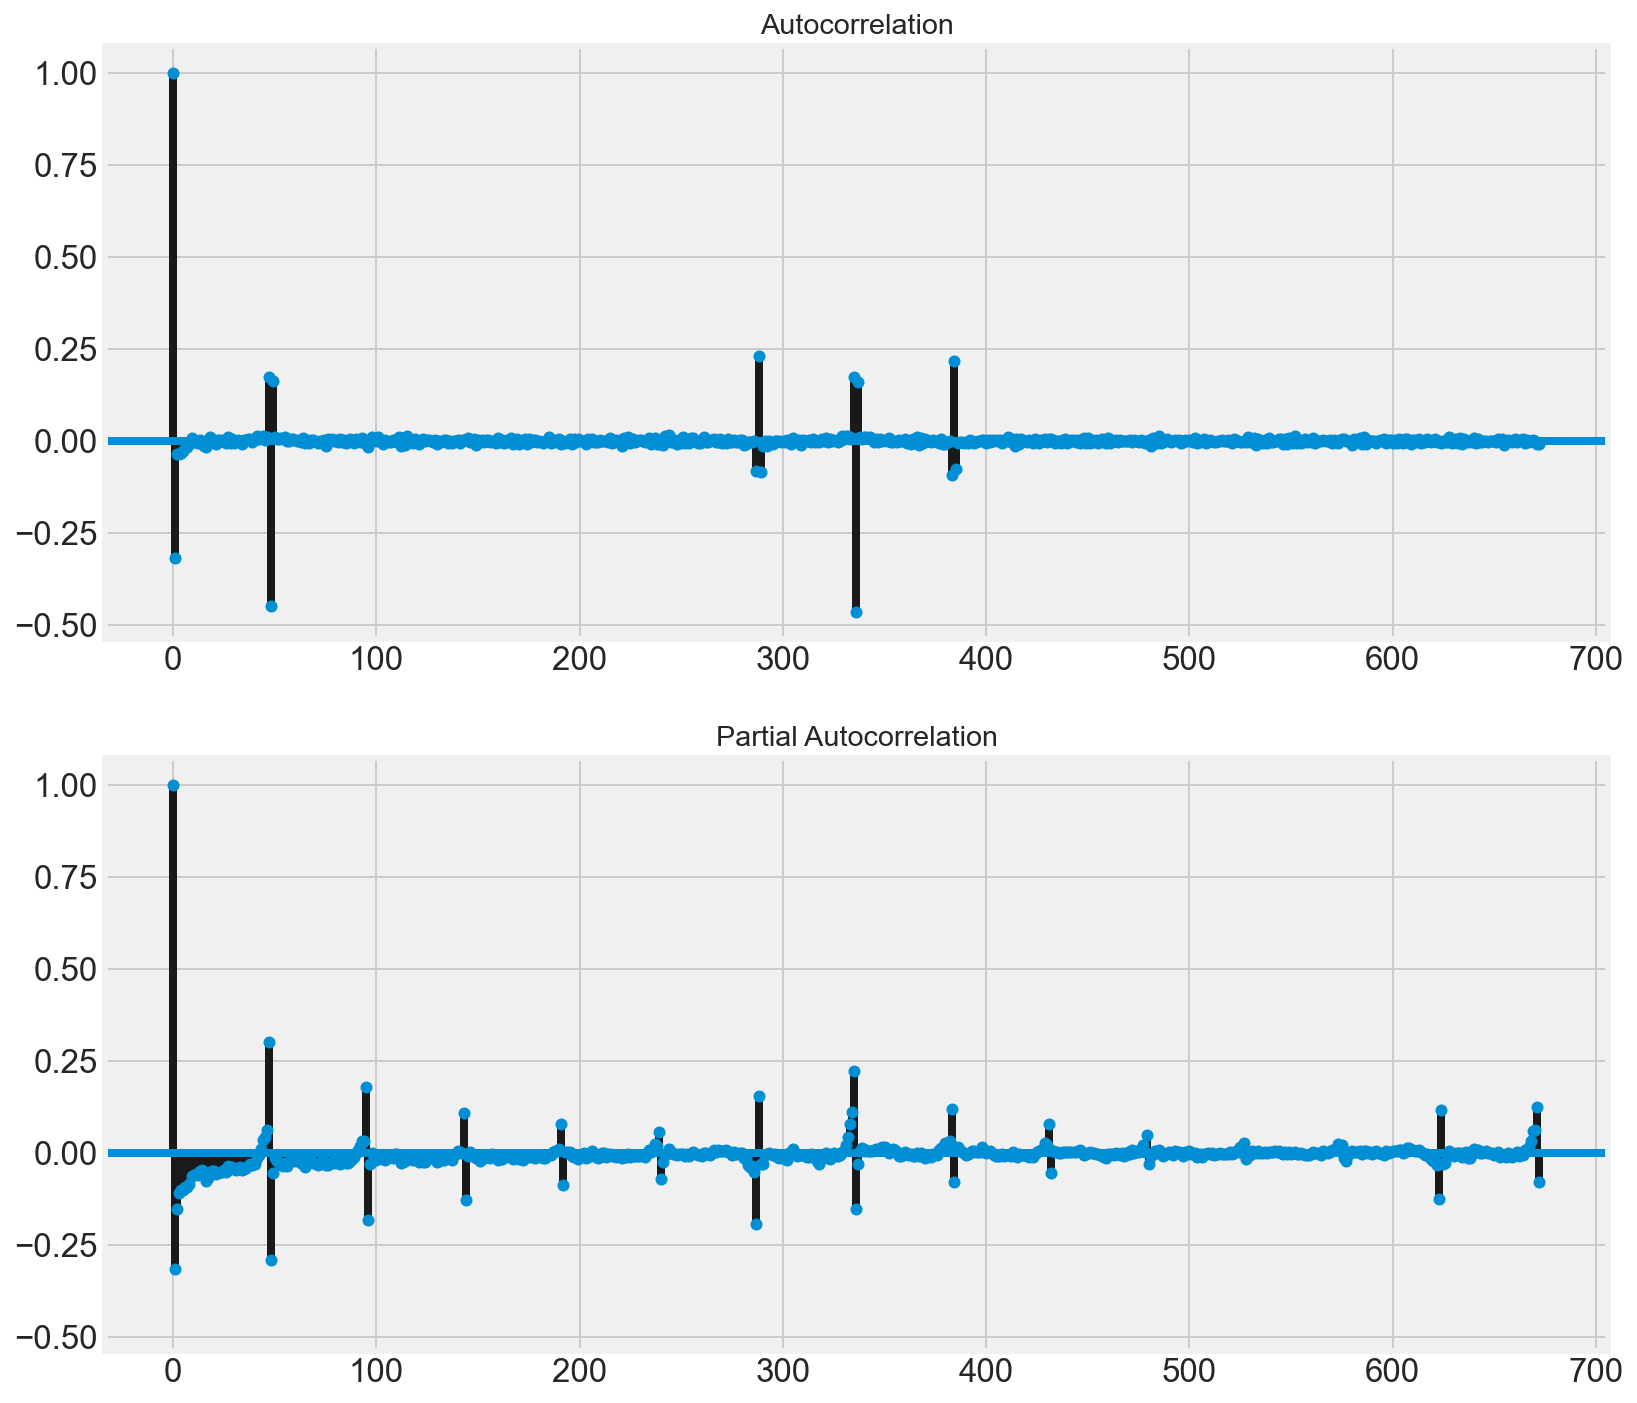

In [162]:
autocorr_plots(demand.diff().diff().diff(48).diff((48*7)).dropna(), lags=(48*7*2))
# better without that second daily differencing. But is it better with weekly differncing than before?

Need some serious examining these plots to determine what the best way forward with modelling is. This looks a lot a lot tighter than without the weekly component. But there are extra clearly significant autocorrelations now. So are these now used as regressors in the model? Simple as that? Do I read from the ACF or the PACF? What does this plot show? All this differencing for stationarity might actually have completely transformed the best model into an MA. Maybe the way of dealing with the stationarity is to use the lags as regressors, not to actually difference. I need to read a paper.

*This differencing appears to have alleviated some of the non-stationarity associated with daily seasonality. We can still see evidence for weekly seasonality which should be dealt with. What's the negative association we see now? We're looking at autocorrelations for 48-period differences - e.g. the difference between today's 12pm demand and yesterday's 12pm demand. You can imagine that the difference in demand between Sunday and Monday this week will be positively correlated with the same difference last week -- probably a positive value will be characteristic of the two.